In [ ]:
# 성능 향상을 위해 사용한 방법

# Epoch 늘리기
# CNN 내부에 더 많은 레이어 쌓기
# Drop-out을 통한 과적합 방지
# 데이터 변형(렌덤 크롭)을 통해 대이터 다양화 
# Batch_Normalization

In [ ]:
import torch # for pytorch
import torch.nn as nn # for neural network
import torch.nn.functional as F # 활성화 함수 손실 함수
import torch.optim as optim 
from torch.utils.data import DataLoader 

# 데이터셋 불러오기 위함
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.get_device_name(0))

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
device

True
1.11.0+cu113
Tesla T4


device(type='cuda')

In [ ]:
# 전처리 설정
# 텐서로 바꿔주고 정규화
transform1 = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# 실질적인 데이터 불러오기
# transforms로 불러오는 동시에 전처리
trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform1)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform1)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 16 # 4 -> 16으로 증가

In [ ]:
# Dataloader: batch_size 형태로 만들어서 실제로 학습할때 이용할 수 있는 형태로 만든다
trainloader1 = DataLoader(trainset1,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=2)
testloader = DataLoader(testset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=2)

In [ ]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# ============================ 데이터 다양화 =====================================

In [ ]:
transform2 = transforms.Compose([
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.RandomCrop(32,padding=4),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform2)

trainloader2 = DataLoader(trainset2,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=2)

Files already downloaded and verified


In [ ]:
# ============================= 데이터 확인 ====================================

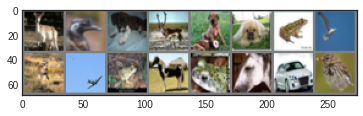

deer  bird  dog   deer  dog   dog   frog  bird  deer  airplane frog  horse frog  horse automobile bird 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader1)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

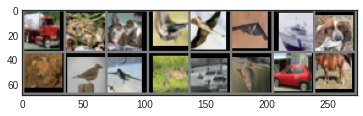

truck frog  cat   bird  bird  airplane ship  dog   frog  bird  airplane deer  ship  bird  automobile horse


In [ ]:
dataiter = iter(trainloader2)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# ======================================== 신경망 설정 ===================================================================

In [ ]:
# Batch_normalization 적용

# Drop-Out 적용
# 과적합 방지
# Convolution -> Batch Normalization -> Activation(Relu) -> " Dropout " -> Pooling 순이 적절

# 채널수 증가
# layer 수 증가

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5) # (입력 채널 수: 3, 출력 채널수 32, 필터(커널) 크기: 5x5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5) # 합성곱 연산 (입력 채널 수: 6, 출력 채널수 64, 필터(커널) 크기: 5x5)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5) # conv layer 추가
        
        self.pool = nn.MaxPool2d(2, 2, 1) # max pooling (필터 크기: 2x2) padding: 1 (이미지 픽셀이 너무 작아지는 것 방지)

        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 84)
        self.fc4 = nn.Linear(84, 10) # Full-connection layer도 추가

        self.dropout1 = nn.Dropout(p = 0.5, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.conv3(x))
        x = self.dropout1(x) # <- 이 시점에서 Drop-out 진행
        x = self.pool(x)
        
        x = x.view(-1, 128*2*2) # 2x2 피처맵 64개를 일렬로 만든다
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout1(x) # <- 이 시점에서 Drop-out 진행
        x = F.relu(self.bn4(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net().to(device) # 모델 선언

In [ ]:
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)


In [ ]:
criterion = nn.CrossEntropyLoss() # 분류문제에 적합
optimizer = optim.Adam(net.parameters(), lr=0.001) # Adam 사용

In [ ]:
# Data augmentation 유
for epoch in range(40): # n번 훈련

    running_loss = 0.0 # 오차 초기화
    for i, data in enumerate(trainloader2, 0): # 데이터를 가져와서 하나씩 분할
        inputs, labels = data[0].to(device), data[1].to(device) # 그림, 레이블 GPU로 받기 (한번에 배치 사이즈 크기만큼 불러오기)

        optimizer.zero_grad() # 가중치 초기화(이전에 있었을 지도 모르는)

        outputs = net(inputs) # net에 input 전달
        loss = criterion(outputs, labels) # CrossEntropy로 Loss 계산
        loss.backward() # Loss를 backward시켜서 업데이트 (back-propagation)
        optimizer.step() # Adam을 통해 최적화 / 훈련에 적용 
        # --------- 훈련 마침 --------
        # 2000번 마다 loss출력
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print('Fin')

Epoch: 1, Batch: 2000, Loss: 1.8879121401906014
Epoch: 2, Batch: 2000, Loss: 1.643178062438965
Epoch: 3, Batch: 2000, Loss: 1.5220794814527034
Epoch: 4, Batch: 2000, Loss: 1.4405304257571698
Epoch: 5, Batch: 2000, Loss: 1.3659776556491852
Epoch: 6, Batch: 2000, Loss: 1.3125737559199333
Epoch: 7, Batch: 2000, Loss: 1.269280132293701
Epoch: 8, Batch: 2000, Loss: 1.2362939288169146
Epoch: 9, Batch: 2000, Loss: 1.21768264067173
Epoch: 10, Batch: 2000, Loss: 1.202727359831333
Epoch: 11, Batch: 2000, Loss: 1.1718068388849496
Epoch: 12, Batch: 2000, Loss: 1.1636831761300563
Epoch: 13, Batch: 2000, Loss: 1.1517741395682097
Epoch: 14, Batch: 2000, Loss: 1.130125070825219
Epoch: 15, Batch: 2000, Loss: 1.1115240470170975
Epoch: 16, Batch: 2000, Loss: 1.1074144179672003
Epoch: 17, Batch: 2000, Loss: 1.096156043127179
Epoch: 18, Batch: 2000, Loss: 1.0885941313058138
Epoch: 19, Batch: 2000, Loss: 1.0705896345376968
Epoch: 20, Batch: 2000, Loss: 1.0727970364391803
Epoch: 21, Batch: 2000, Loss: 1.0629

In [ ]:
# Data augmentation 무
for epoch in range(40): # n번 훈련

    running_loss = 0.0 # 오차 초기화
    for i, data in enumerate(trainloader1, 0): # 데이터를 가져와서 하나씩 분할
        inputs, labels = data[0].to(device), data[1].to(device) # 그림, 레이블 GPU로 받기 (한번에 배치 사이즈 크기만큼 불러오기)

        optimizer.zero_grad() # 가중치 초기화(이전에 있었을 지도 모르는)

        outputs = net(inputs) # net에 input 전달
        loss = criterion(outputs, labels) # CrossEntropy로 Loss 계산
        loss.backward() # Loss를 backward시켜서 업데이트 (back-propagation)
        optimizer.step() # Adam을 통해 최적화 / 훈련에 적용 
        # --------- 훈련 마침 --------
        # 2000번 마다 loss출력
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print('Fin')

Epoch: 1, Batch: 2000, Loss: 0.8176862242072821
Epoch: 2, Batch: 2000, Loss: 0.755327029503882
Epoch: 3, Batch: 2000, Loss: 0.723956117965281
Epoch: 4, Batch: 2000, Loss: 0.6961257261633873
Epoch: 5, Batch: 2000, Loss: 0.6852246462851763
Epoch: 6, Batch: 2000, Loss: 0.6524922651574016
Epoch: 7, Batch: 2000, Loss: 0.6390938448160887
Epoch: 8, Batch: 2000, Loss: 0.6263799748234451
Epoch: 9, Batch: 2000, Loss: 0.6120027188286186
Epoch: 10, Batch: 2000, Loss: 0.5980548846051097
Epoch: 11, Batch: 2000, Loss: 0.5951446167416871
Epoch: 12, Batch: 2000, Loss: 0.5689049009438604
Epoch: 13, Batch: 2000, Loss: 0.5606656150184571
Epoch: 14, Batch: 2000, Loss: 0.5516393627263606
Epoch: 15, Batch: 2000, Loss: 0.553868686504662
Epoch: 16, Batch: 2000, Loss: 0.5356506160758435
Epoch: 17, Batch: 2000, Loss: 0.5204040706492961
Epoch: 18, Batch: 2000, Loss: 0.5177684402577579
Epoch: 19, Batch: 2000, Loss: 0.5142951172282919
Epoch: 20, Batch: 2000, Loss: 0.5067416049111635
Epoch: 21, Batch: 2000, Loss: 0.

In [ ]:
path = './cifar_net.pth'
torch.save(net.state_dict(),path)

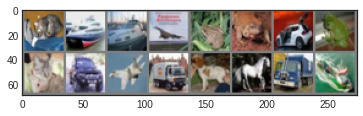

	cat 	ship 	ship 	airplane 	frog 	frog 	automobile 	frog 	cat 	automobile 	airplane 	truck 	dog 	horse 	truck 	ship


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(batch_size)))

In [ ]:
net = Net().to(device)
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
outputs = net(images.to(device))

In [ ]:
_, predicted = torch.max(outputs, 1)
print(' '.join('\t{}'.format(classes[predicted[j]]) for j in range(batch_size)))

	cat 	ship 	ship 	airplane 	frog 	cat 	cat 	frog 	cat 	truck 	airplane 	truck 	dog 	horse 	truck 	ship


In [ ]:
# 성능 일부 확인
# 정확도: 13/16, 81.25%

In [ ]:
# =============== 성능 전체 확인 ===================================================================

In [ ]:
correct = 0 # 맞은 개수
total = 0 # 시험본 개수
 
# 학습 중이 아니므로(테스트 중임으로), 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 75 %


In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 78.6 %
Accuracy for class: automobile is 86.0 %
Accuracy for class: bird  is 69.0 %
Accuracy for class: cat   is 56.7 %
Accuracy for class: deer  is 70.8 %
Accuracy for class: dog   is 65.2 %
Accuracy for class: frog  is 83.2 %
Accuracy for class: horse is 75.5 %
Accuracy for class: ship  is 83.2 %
Accuracy for class: truck is 84.7 %
